In [1]:
import umap
import umap.plot
from pynndescent import NNDescent
import pandas as pd
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('bmh')

### Import processed data

In [2]:
train = pd.read_csv("../../AnomalyDetection/processedData/TrainingData_normal.csv")
dev = pd.read_csv("../../AnomalyDetection/processedData/DevData_normal.csv")
test = pd.read_csv("../../AnomalyDetection/processedData/hold_outset_moreFraud.csv")

In [3]:
train["Class"], dev["Class"] = 0, 0 
data = pd.concat([train,dev,test])

In [4]:
data.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

### select similar num of Class 0 and 1

In [5]:
normal = data[data["Class"] == 0].sample(5000,replace=False)
fraud = data[data["Class"]==1]

In [6]:
feature_df = pd.concat([normal,fraud],axis=0)
X, y = feature_df.drop("Class",axis=1), feature_df.Class

### Create feature map 

In [9]:
feature_map = umap.UMAP().fit(X)

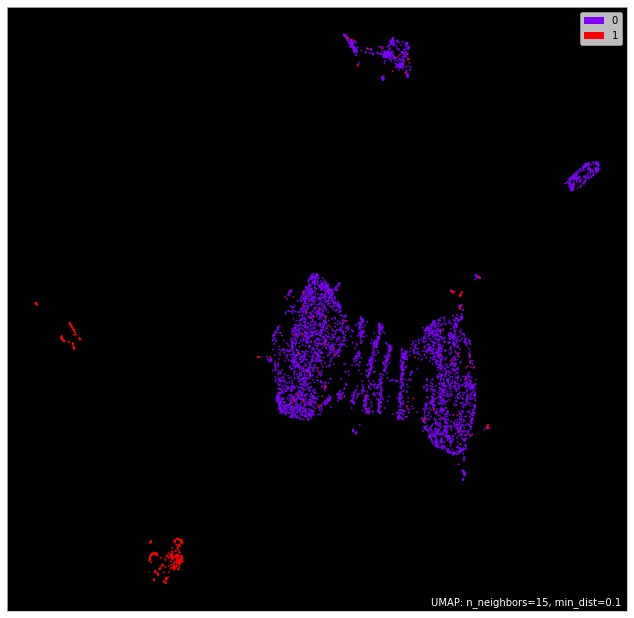

In [10]:
umap.plot.points(feature_map, labels = y, theme = "fire")
plt.show()

### You can see decent separation between Fraud and normal transactions among 5 clusters

### perform unsupervised fitting 

In [12]:
unsupervised_embed= umap.UMAP().fit_transform(X)

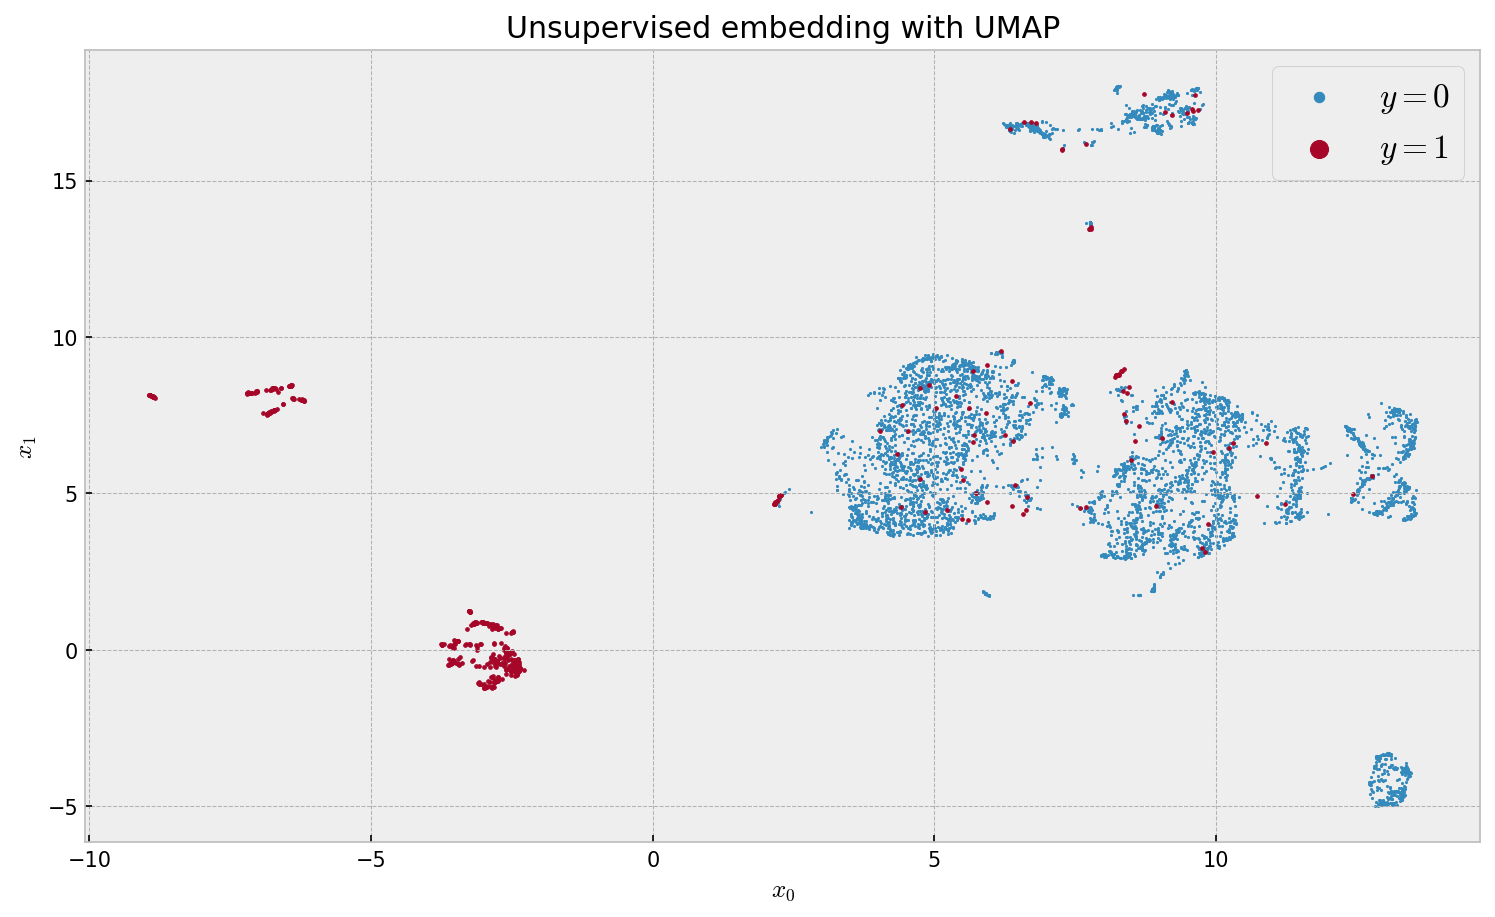

In [13]:
plt.figure(figsize=(12,7), dpi=150)
cmap = plt.get_cmap("viridis")
plt.scatter(unsupervised_embed[y == 0,0], unsupervised_embed[y == 0,1], s=1, c='C0', cmap='fire', label='$y=0$')
plt.scatter(unsupervised_embed[y == 1,0], unsupervised_embed[y == 1,1], s=3, c='C1', cmap='fire', label='$y=1$')
plt.title('Unsupervised embedding with UMAP')
plt.xlabel('$x_0$'); plt.ylabel('$x_1$')
plt.legend(fontsize=16, markerscale=5);

### Have decent separation with 6 clusters

### Perform supevised UMAP fitting with target

In [14]:
supervised_embed = umap.UMAP().fit_transform(X,y=y)

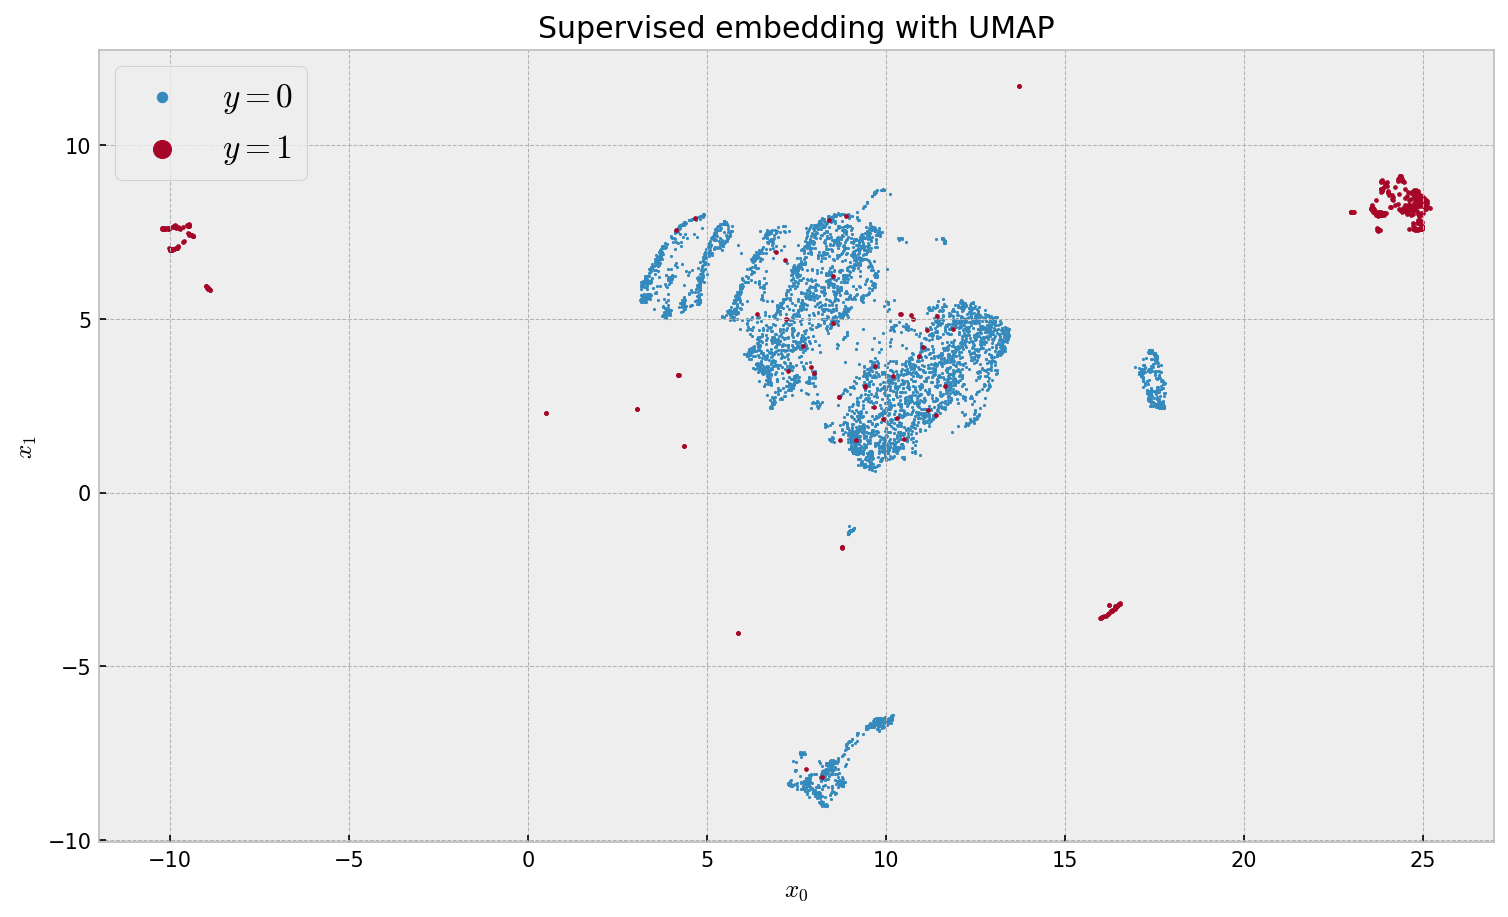

In [15]:
plt.figure(figsize=(12,7), dpi=150)
cmap = plt.get_cmap("viridis")
plt.scatter(supervised_embed[y == 0,0], supervised_embed[y == 0,1], s=1, c='C0', cmap=cmap, label='$y=0$')
plt.scatter(supervised_embed[y == 1,0], supervised_embed[y == 1,1], s=3, c='C1', cmap=cmap, label='$y=1$')
plt.title('Supervised embedding with UMAP')
plt.xlabel('$x_0$'); plt.ylabel('$x_1$')
plt.legend(fontsize=16, markerscale=5)
plt.show()

### Decent separation with 7 clusters

### Forest Embedding:
   * Better improve feature extaction, a supervised model is used

In [16]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import classification_report

In [17]:
tree = ExtraTreesClassifier(n_estimators=150, min_samples_leaf=500, max_features=0.8, 
                           bootstrap=True, class_weight = "balanced", n_jobs = 20)
sKF = StratifiedKFold(n_splits = 3, shuffle=True)
preds = cross_val_predict(tree, X, y, cv=sKF)

In [18]:
print(classification_report(y,preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5000
           1       0.85      0.87      0.86       492

    accuracy                           0.98      5492
   macro avg       0.92      0.93      0.93      5492
weighted avg       0.98      0.98      0.98      5492



### Model application to improve embedding (results are pretty decent)

In [19]:
tree.fit(X,y)

ExtraTreesClassifier(bootstrap=True, class_weight='balanced', max_features=0.8,
                     min_samples_leaf=500, n_estimators=150, n_jobs=20)

In [20]:
leaves = tree.apply(X)

In [21]:
print(leaves)  # leave assignment for reach sample 

[[7 8 2 ... 7 2 7]
 [4 8 7 ... 4 2 7]
 [5 5 5 ... 4 1 6]
 ...
 [5 1 2 ... 2 2 7]
 [1 1 2 ... 7 2 7]
 [1 1 2 ... 7 2 7]]


In [22]:
sup_embed_tree = umap.UMAP(metric="hamming").fit_transform(leaves)

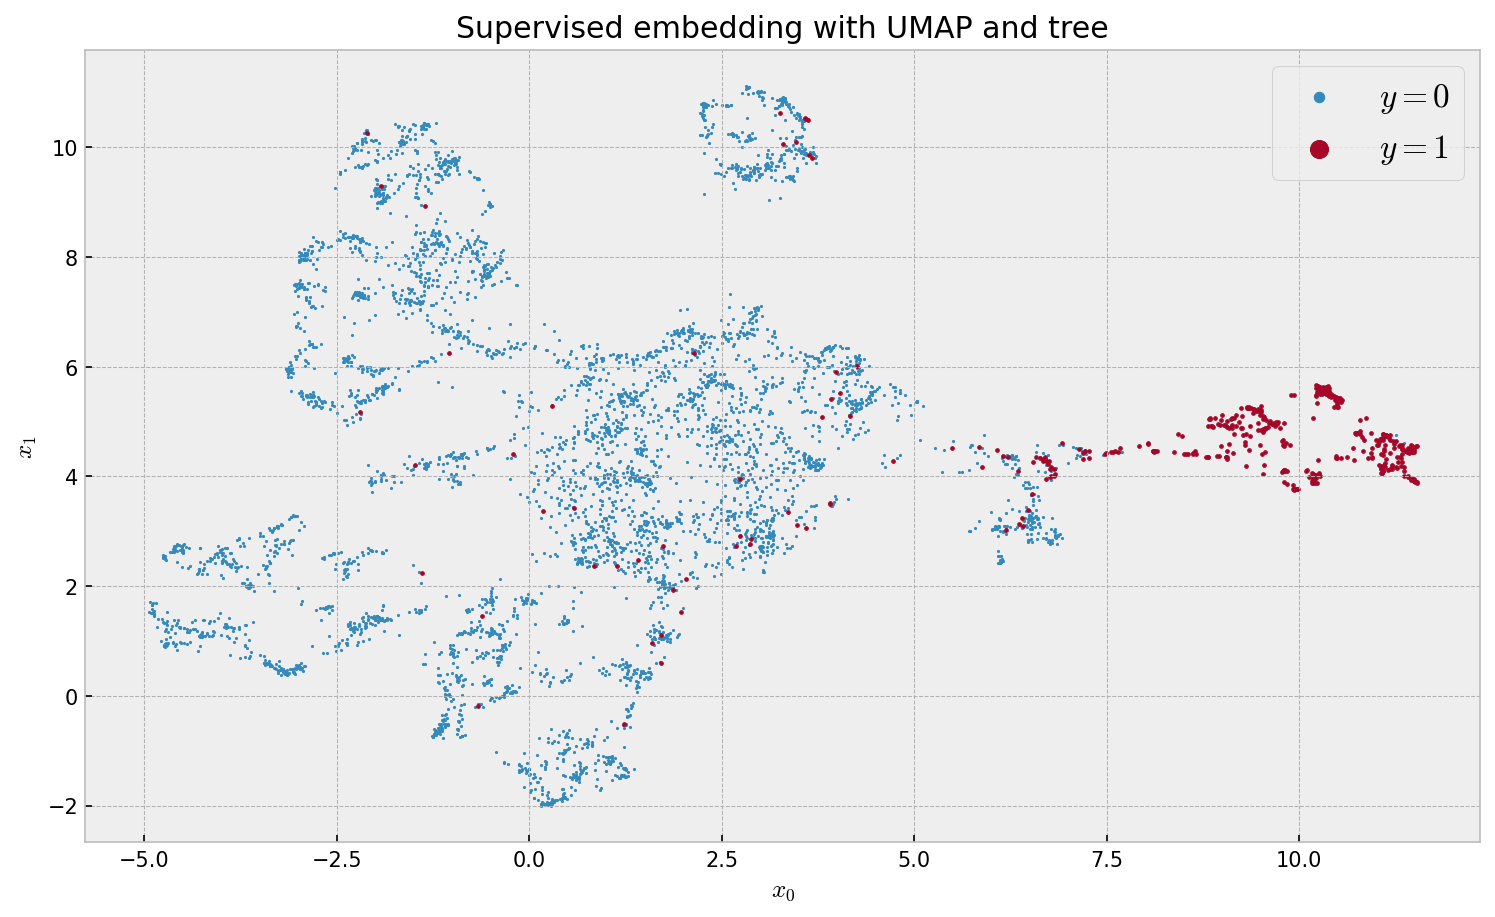

In [23]:
plt.figure(figsize=(12,7), dpi=150)
cmap = plt.get_cmap("viridis")
plt.scatter(sup_embed_tree[y == 0,0], sup_embed_tree[y == 0,1], s=1, c='C0', cmap=cmap, label='$y=0$')
plt.scatter(sup_embed_tree[y == 1,0], sup_embed_tree[y == 1,1], s=3, c='C1', cmap=cmap, label='$y=1$')
plt.title('Supervised embedding with UMAP and tree')
plt.xlabel('$x_0$'); plt.ylabel('$x_1$')
plt.legend(fontsize=16, markerscale=5)
plt.show()

In [28]:
importances = pd.DataFrame({"importance":tree.feature_importances_,
                           "variable":X.columns})
importances.sort_values("importance",ascending=False).head(10)

,importance,variable
10,0.118574,V11
3,0.105322,V4
11,0.090138,V12
0,0.086776,V1
13,0.071913,V14
2,0.069744,V3
8,0.060782,V9
17,0.046664,V18
29,0.037494,Time_hourly
1,0.037212,V2


### appears to have 7 major clusters (varibale V11,V4,V12,V1,V14,V3, and the rest seem to be close together)